# TMDB Box Office Prediction
Can you predict a movie's worldwide box office revenue?
![](img/cine.jpeg)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import requests
import json

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /Users/pedro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
d = pd.read_csv('data/train.csv')
d.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [3]:
'Columns are: ' + ', '.join(d.columns.values)

'Columns are: id, belongs_to_collection, budget, genres, homepage, imdb_id, original_language, original_title, overview, popularity, poster_path, production_companies, production_countries, release_date, runtime, spoken_languages, status, tagline, title, Keywords, cast, crew, revenue'

Below is a short description of the features of our data:
* __Id__: counter starting at 1
* __belongs_to_collection__ : list of collections the title belongs to.'NA' if they do not belong
* __budget__ : budget of the title, some are 0 which seems to be missing data
* __genres__: list of genres the title belongs to. 'NA' if unclassified
* __homepage__: webadress for the title if it exists
* __imdb_id__: id of the movie in the imdb.
* __original_language__: 2 leter code of the original language of the movie
* __original_title__: title of the movie in the original.
* __overview__ : short description of the title 
* __popularity__ : some kind of popularity score
* __poster_path__ : image of the poster
* __production_companies__: list of production companies involved
* __production_countries__: list of production countries involved
* __release_data__ : release date as string in format mm/dd/yy
* __runtime__ : length of the movie in minutes
* __spoken_languages__: list of languange codes spoken in the film
* __status__: either released or rumored. Only four rumored. Seems to be an useless field.
* __tagline__: line under the title. if available
* __title__: name of the film
* __cast__: list of dictionaries containing, characters name, gender, order and actors name.
* __crew__: list of dictionaries containing information about the films crew.
* __revenue__: revenue of the films. I will assume it is normalized for inflation?

Many of the features are lists or dictionaries transformed into strings. I will extract the relevant information from belongs_to_collection, genres, production_companies, production_countries, spoken_languages, Keywords, cast and crew.

In [4]:
def parse_listdict_columns(data, column, key='name', fillna=False, na_value = 'NA', replace=True):
    new_column_name = '{}_{}'.format(column, key)
    data[new_column_name] = data[column].map(literal_eval, na_action='ignore')
    data[new_column_name] = data[new_column_name].map(lambda l: [i[key] for i in l], na_action='ignore')
    if fillna:
        data[new_column_name].fillna(value=na_value, inplace=True)
    if replace:
        data[column] = data[new_column_name]
        data.drop(new_column_name, axis='columns', inplace=True)
    return

In [5]:
parse_listdict_columns(d, 'belongs_to_collection', fillna=True, na_value='No collection')
parse_listdict_columns(d, 'genres')
parse_listdict_columns(d, 'production_companies')
parse_listdict_columns(d, 'production_countries', key='iso_3166_1')
parse_listdict_columns(d, 'spoken_languages', key='iso_639_1')
parse_listdict_columns(d, 'Keywords')
parse_listdict_columns(d, 'cast', key='gender', replace=False)
parse_listdict_columns(d, 'cast', key='name', replace=False)
parse_listdict_columns(d, 'crew', key='department', replace=False)
parse_listdict_columns(d, 'crew', key='gender', replace=False)
parse_listdict_columns(d, 'crew', key='id', replace=False)
parse_listdict_columns(d, 'crew', key='job', replace=False)
parse_listdict_columns(d, 'crew', key='name', replace=False)

We will now look at the NaN's of our data and either drop them or impute them

In [6]:
def display_nans(data):
    nans_per_col = data.isnull().sum()
    nans_per_row = data.isnull().sum(axis=1)
    fig, [ax_col,ax_row] = plt.subplots(1,2, figsize=(16,6))
    nans_per_col[nans_per_col>0].plot.barh(ax=ax_col)
    nans_per_row.hist(bins=np.arange(0,20,1), ax=ax_row)

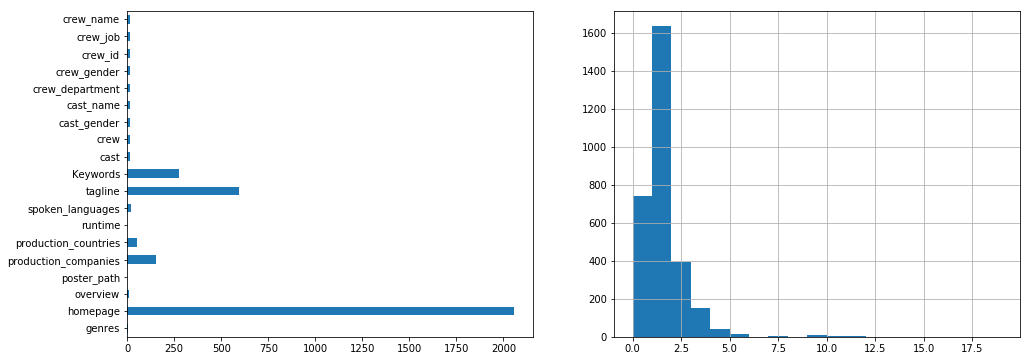

In [7]:
display_nans(d)

Let's start by the most obvious issues: 
* homepage is irrelevant since NaNs are missing information (e.g. minority report is missing). There are many homepages missing (more than half) so I will drop this feature.
* belongs to collection has already been imputed with "No collection" 
* It is perfectly ok to not have a tagline. It could be that is missing but I will assume that NaNs symbolise that the title has to tagline


In [8]:
d.drop('homepage', axis='columns', inplace=True)
d.tagline.fillna('', inplace=True)

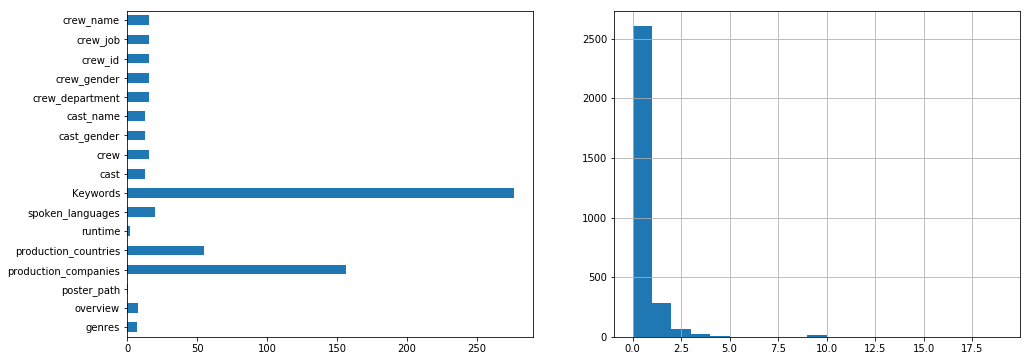

In [9]:
display_nans(d)

Many key words are missing, and it seems a very interesting feature to have. I will try to impute the missing values with information from the overview. I'll create a bag of words of all the keywords used and check for them in the overviews. I'll assume that the keywords that exist are more accurate that the imputed ones, so I will keep them and only impute on NaNs.

In [10]:
keywords = set({})
for keys in d.Keywords.dropna():
    keys = [key.lower() for key in keys]
    keywords = keywords.union(set(keys))


In [11]:
def get_keywords(text, possible_keywords):
    words = word_tokenize(text)
    words = set([word.lower() for word in words])
    return list(words & possible_keywords)

In [12]:
d['created_keywords'] = d.overview.map(lambda text: get_keywords(text, keywords), na_action='ignore')
d.Keywords.fillna(d.created_keywords, inplace=True)
d.drop('created_keywords', axis=1, inplace=True)

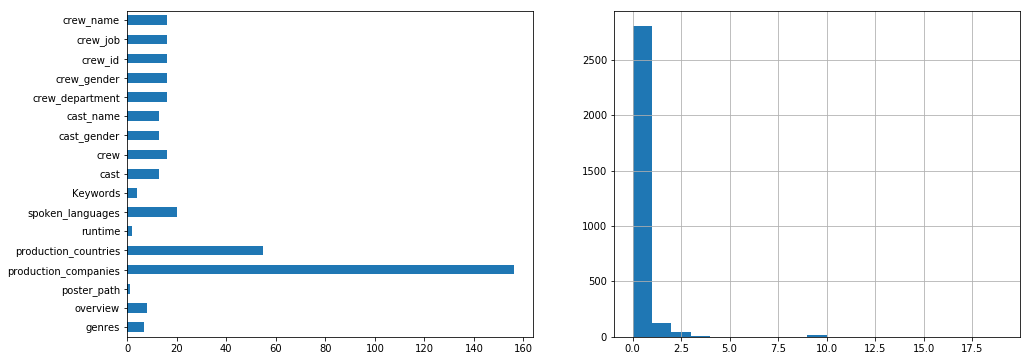

In [13]:
display_nans(d)

We are down to 160 missing values on our top feature in missing values. Using IMDBAPI free key (only 2000 daily requests) I will download data for the missing features

In [14]:
#Code used to query the API and extract additional information
"""
missing_info = {}
for imdb_id in d[d.isnull().sum(axis=1) > 0].imdb_id:
    url = 'http://www.omdbapi.com/?i={}&plot=full&apikey=c3551bb2'.format(imdb_id)
    r = requests.get(url)
    missing_info[imdb_id] = r.json()
with open('data/missing_data.json', 'w') as fp:
    json.dump(missing_info, fp)
"""

"\nmissing_info = {}\nfor imdb_id in d[d.isnull().sum(axis=1) > 0].imdb_id:\n    url = 'http://www.omdbapi.com/?i={}&plot=full&apikey=c3551bb2'.format(imdb_id)\n    r = requests.get(url)\n    missing_info[imdb_id] = r.json()\nwith open('data/missing_data.json', 'w') as fp:\n    json.dump(missing_info, fp)\n"

In [15]:
with open('data/missing_data.json', 'r') as json_file:  
    missing_info = json.load(json_file)

In [16]:
#Create a dictionary for country names to country codes based on the data that we already have
d_aux = pd.read_csv('data/train.csv')
code_country = {}
for film in d_aux.dropna(subset=['production_countries']).iterrows():
    countries = literal_eval(film[1]['production_countries'])
    for country in countries:
        code_country[country['name']] = country['iso_3166_1']
code_country['USA'] = 'US'
code_country['UK'] = 'GB'
code_country['Thailand'] = 'TH'

In [17]:
# Modify the fields of out missing_info to list of codes for country and a list of one item for the production comp.
for film in missing_info:
    countries = missing_info[film]['Country'].strip().split(', ')
    codes = []
    for country in countries:
        codes.append(code_country[country])
    missing_info[film]['country_codes'] = codes
    missing_info[film]['production_companies'] = [missing_info[film]['Production']]

In [18]:
tmdb_info = {'production_companies' : 'production_companies',
             'production_countries': 'country_codes'}
ja = 0
nej = 0
for film in d[d.isnull().sum(axis=1) > 0].iterrows():
    idx = film[0]
    film = film[1]
    imdb_id = film['imdb_id']
    info = missing_info[imdb_id]
    for missing_feature in film[film.isnull()].index:
        try:
            d.loc[idx, missing_feature] = info[tmdb_info[missing_feature]]
            ja += 1
        except:
            nej += 1
print('{} values where imputed, {} could not be imputed'.format(ja, nej))

199 values where imputed, 189 could not be imputed


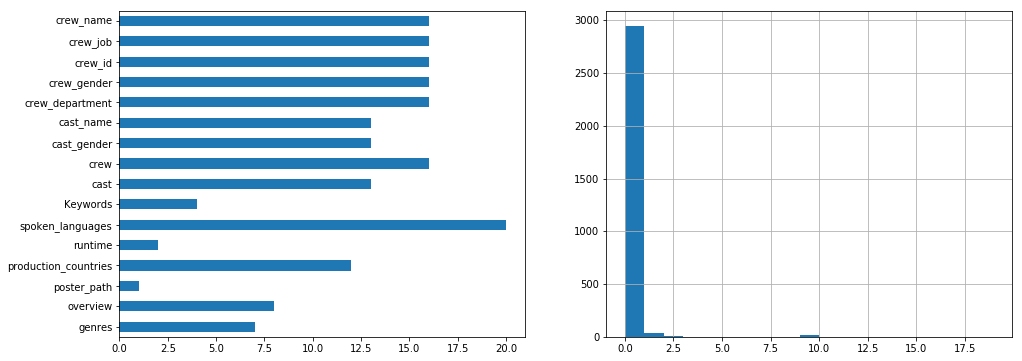

In [19]:
display_nans(d)

We have not reduced the number of missing values to just 56 rows which we will now drop to have a clean dataset, we also won't need some features: poster_path, imdb_id, cast, crew and status

In [20]:
d.drop(['poster_path', 'imdb_id', 'cast', 'crew', 'status'], axis=1, inplace=True)
d.dropna(inplace=True)
d.shape

(2944, 24)

In [24]:
d.production_companies.value_counts()

[Paramount Pictures]                                                                                                                     51
[Universal Pictures]                                                                                                                     36
N/A                                                                                                                                      33
[Warner Bros.]                                                                                                                           32
[Metro-Goldwyn-Mayer (MGM)]                                                                                                              31
[Twentieth Century Fox Film Corporation]                                                                                                 24
[New Line Cinema]                                                                                                                        17
[Touchstone Pictures